In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import maxwell

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
np.random.seed(1)

In [3]:
N = 128
rho = 0.4
#L = .4 * N
#L = (N/rho)**(1/3)
L = 50
lam = 0.1931833275037836

In [4]:
def initialize(N, L, T, lattice_constant):
    
    positions = list(np.arange(-L/2., L/2., lattice_constant))
    r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    r0 = r0[np.random.randint(len(r0), size=N)]
    
    #r_norm = 10
    #while r_norm > L/20:
    #    r0 = np.random.uniform(-L/2, L/2, size=(N,3))
    #    r_norm = np.linalg.norm(r0, axis=1).min()
    
    p0 = maxwell.rvs(loc=0, scale=T, size=(N,3)) / np.sqrt(T)
    
    return r0, p0

In [5]:
def calc_energy(r, p, sigma, periodic=None):
    if periodic is None:
        periodic = {'PBC': False,
                    'box_size': 0,
                    'closed': False}

    idx = np.arange(len(r))
    pairs = np.meshgrid(idx, idx)
    separations = r[pairs[0]] - r[pairs[1]]

    if periodic['PBC']:
        separations[np.where(separations > periodic['box_size'] / 2.)] -= periodic['box_size']
        separations[np.where(separations < -periodic['box_size'] / 2.)] += periodic['box_size']

    distances = np.triu(np.linalg.norm(separations, axis=-1))

    V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
    V[np.isnan(V)] = 0.
    V = V.sum()
    
    T = .5 * np.linalg.norm(p)**2
    
    return V + T

In [6]:
r_init, p_init = initialize(N=N, L=L, T=1.5, lattice_constant=(1/rho)**(1/3.))

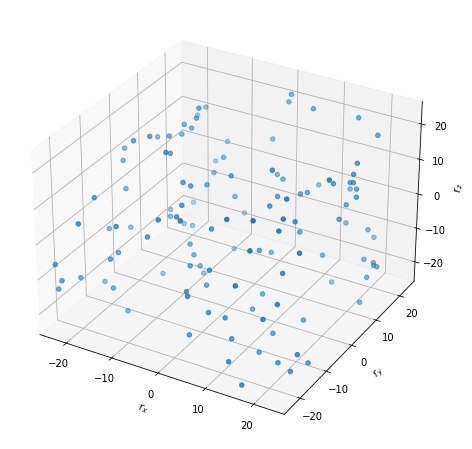

In [7]:
fig0 = plt.figure(figsize=(12,8));
ax0 = fig0.add_subplot(111, projection='3d')
ax0.scatter(r_init[:,0], r_init[:,1], r_init[:,2])
ax0.set_xlabel(r'$r_x$')
ax0.set_ylabel(r'$r_y$')
ax0.set_zlabel(r'$r_z$')
ax0.set_xlim(-L/2+.2,L/2+.2)
ax0.set_ylim(-L/2+.2,L/2+.2)
ax0.set_zlim(-L/2+.2,L/2+.2)
#plt.savefig('./figures/init_pos.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
simulations = []

dt0 = 0.01
for k in range(3):
    dt = 2**k * dt0
    t_sim = 10**3 * dt
    
    #R, P, t = a.BABAB_Ndim(r0=r_init.copy(), p0=p_init.copy(), t_max=t_sim, dt=dt, f=f.LJ_force, lam=lam,
    #                       thermal_noise=False, maxwell_noise=False,
    #                       periodic={'PBC': True, 'box_size': L, 'closed': False})
    
    R, P, t = a.velocity_verlet_Ndim(r0=r_init.copy(), p0=p_init.copy(), t_max=t_sim, dt=dt, f=f.LJ_force,
                                     periodic={'PBC': True, 'box_size': L, 'closed': False})
    
    E = np.zeros(len(t))
    for i in range(len(t)):
        E[i] = calc_energy(R[i], P[i], sigma=1, 
                           periodic={'PBC': True, 'box_size': L, 'closed': False})
    
    simulations.append({'dt': dt,
                        't_sim': t_sim,
                        'R': R,
                        'P': P,
                        't': t,
                        'E': E})

  0%|          | 0/999 [00:00<?, ?it/s]/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:191: RuntimeWarning: divide by zero encountered in true_divide
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:191: RuntimeWarning: invalid value encountered in subtract
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
100%|██████████| 999/999 [00:03<00:00, 253.14it/s]
<ipython-input-5-c07f12e42591>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
<ipython-input-5-c07f12e42591>:17: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma

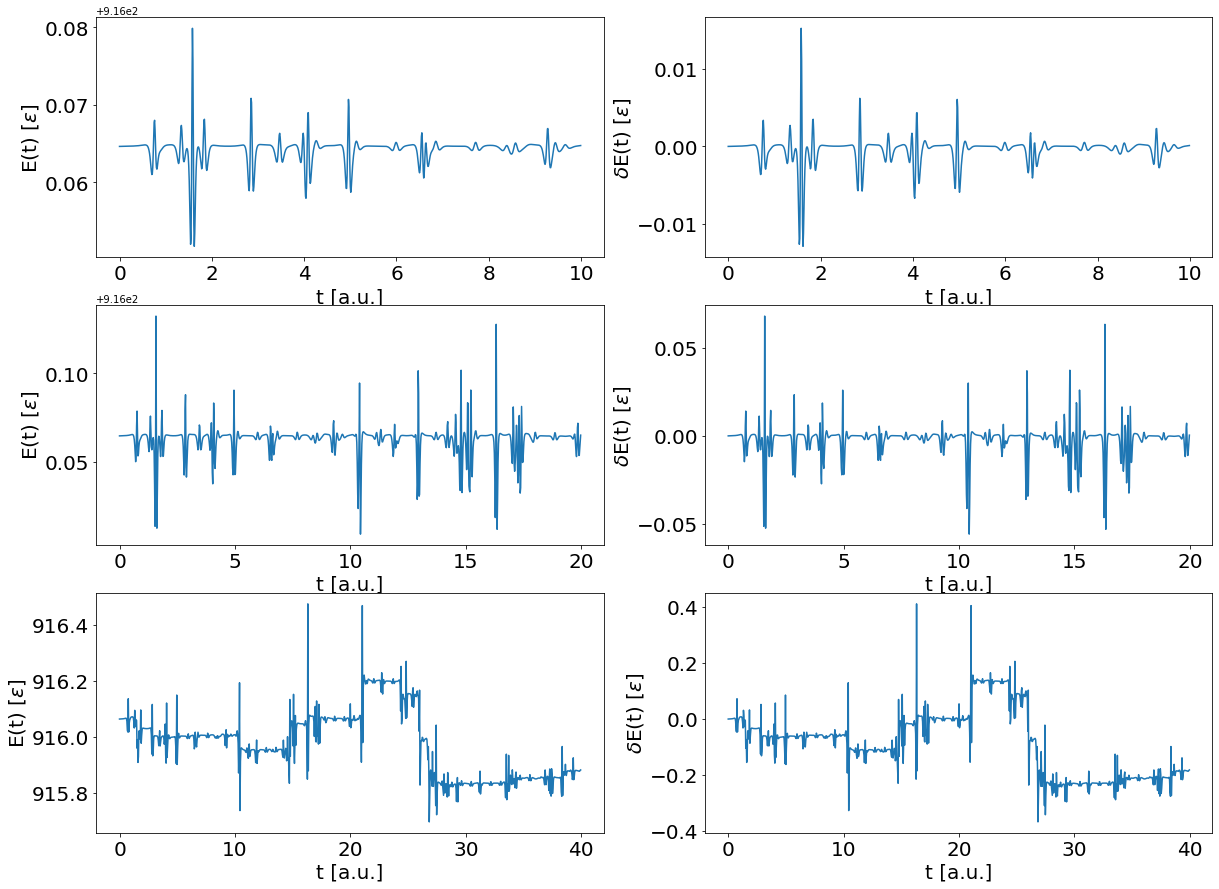

In [9]:
fig1, ax1 = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
ax1[0,0].plot(simulations[0]['t'], simulations[0]['E'])
ax1[0,0].set_xlabel('t [a.u.]', fontsize=20)
ax1[0,0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[0,0].tick_params(axis='x', labelsize=20)
ax1[0,0].tick_params(axis='y', labelsize=20)

ax1[0,1].plot(simulations[0]['t'], (simulations[0]['E']-simulations[0]['E'][0]))
ax1[0,1].set_xlabel('t [a.u.]', fontsize=20)
ax1[0,1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[0,1].tick_params(axis='x', labelsize=20)
ax1[0,1].tick_params(axis='y', labelsize=20)
            
ax1[1,0].plot(simulations[1]['t'], simulations[1]['E'])
ax1[1,0].set_xlabel('t [a.u.]', fontsize=20)
ax1[1,0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[1,0].tick_params(axis='x', labelsize=20)
ax1[1,0].tick_params(axis='y', labelsize=20)

ax1[1,1].plot(simulations[1]['t'], (simulations[1]['E']-simulations[1]['E'][0]))
ax1[1,1].set_xlabel('t [a.u.]', fontsize=20)
ax1[1,1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[1,1].tick_params(axis='x', labelsize=20)
ax1[1,1].tick_params(axis='y', labelsize=20)
            
ax1[2,0].plot(simulations[2]['t'], simulations[2]['E'])
ax1[2,0].set_xlabel('t [a.u.]', fontsize=20)
ax1[2,0].set_ylabel(r'E(t) [$\epsilon$]', fontsize=20)
ax1[2,0].tick_params(axis='x', labelsize=20)
ax1[2,0].tick_params(axis='y', labelsize=20)

ax1[2,1].plot(simulations[2]['t'], (simulations[2]['E']-simulations[2]['E'][0]))
ax1[2,1].set_xlabel('t [a.u.]', fontsize=20)
ax1[2,1].set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax1[2,1].tick_params(axis='x', labelsize=20)
ax1[2,1].tick_params(axis='y', labelsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

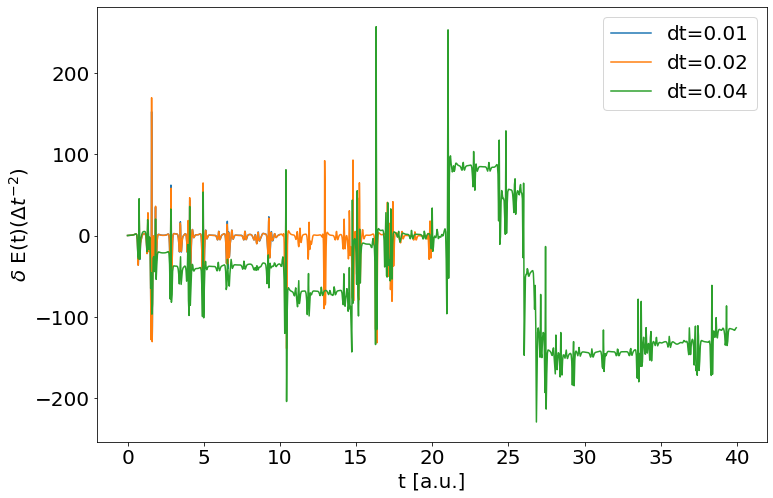

In [10]:
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.plot(simulations[0]['t'], (simulations[0]['E']-simulations[0]['E'][0])*simulations[0]['dt']**(-2), 
         label='dt={}'.format(simulations[0]['dt']))
ax2.plot(simulations[1]['t'], (simulations[1]['E']-simulations[1]['E'][0])*simulations[1]['dt']**(-2),
         label='dt={}'.format(simulations[1]['dt']))
ax2.plot(simulations[2]['t'], (simulations[2]['E']-simulations[2]['E'][0])*simulations[2]['dt']**(-2),
         label='dt={}'.format(simulations[2]['dt']))

ax2.set_xlabel('t [a.u.]', fontsize=20)
ax2.set_ylabel(r'$\delta$ E(t)($\Delta t^{-2}$)', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=20)
plt.show()

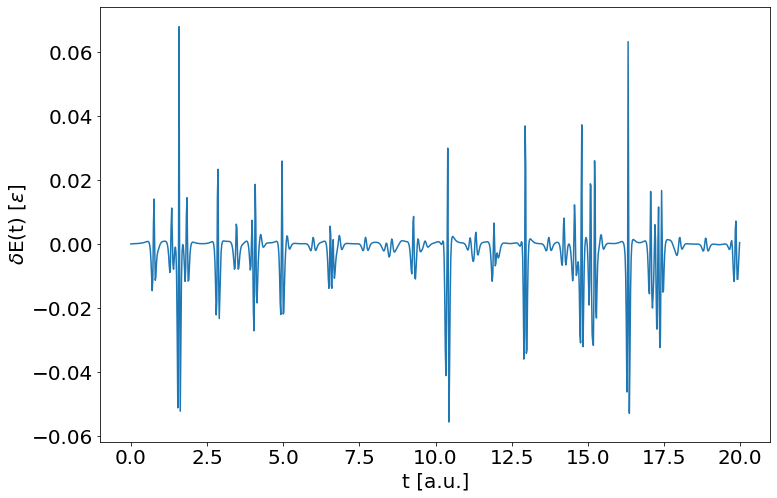

In [11]:
fig3, ax3 = plt.subplots(figsize=(12,8))
ax3.plot(simulations[1]['t'], (simulations[1]['E']-simulations[1]['E'][0]))
ax3.set_xlabel('t [a.u.]', fontsize=20)
ax3.set_ylabel(r'$\delta$E(t) [$\epsilon$]', fontsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.show()

In [12]:
p_total_x = simulations[1]['P'].sum(axis=1)[:,0]
p_total_y = simulations[1]['P'].sum(axis=1)[:,1]
p_total_z = simulations[1]['P'].sum(axis=1)[:,2]

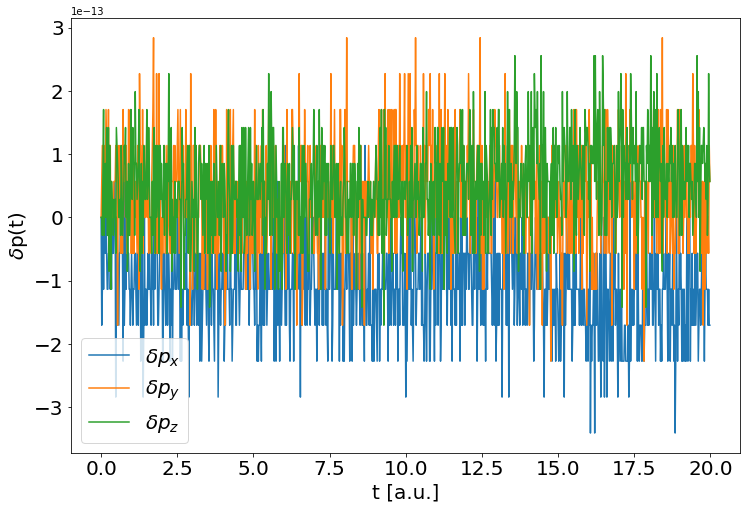

In [13]:
fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax4.plot(simulations[1]['t'], p_total_x-p_total_x[0], label=r'$\delta p_x$')
ax4.plot(simulations[1]['t'], p_total_y-p_total_y[0], label=r'$\delta p_y$')
ax4.plot(simulations[1]['t'], p_total_z-p_total_z[0], label=r'$\delta p_z$')
ax4.set_xlabel('t [a.u.]', fontsize=20)
ax4.set_ylabel(r'$\delta$p(t)', fontsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

#ax4[1].plot(p_total_y-p_total_y[0], label=r'$\delta p_y$')
#ax4[1].set_xlabel('t [a.u.]', fontsize=20)
#ax4[1].set_ylabel(r'$\delta$p(t)', fontsize=20)

#ax4[2].plot(p_total_z-p_total_z[0], label=r'$\delta p_z$')
#ax4[2].set_xlabel('t [a.u.]', fontsize=20)
#ax4[2].set_ylabel(r'$\delta$p(t)', fontsize=20)

plt.legend(fontsize=20)
plt.show()

In [14]:
dE = simulations[1]['E']-simulations[1]['E'][0]
rmsDev = np.sqrt((dE**2).mean() / simulations[1]['E'].mean()**2)
print(rmsDev)

9.417741522591668e-06


In [15]:
absDev = np.sqrt((np.linalg.norm(simulations[1]['P']-simulations[1]['P'][0], axis=(1,2))**2).mean())
print(absDev)

5.739720979532339
